In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
data = pd.read_csv('./Размещения Облигаций - ФД.csv')

In [3]:
data.head()

,Название,ISIN,Рейтинг,Качество Эмитента,Объем,Дата Выпуска,Дата Погашения / Оферты,Купон,Частота Выплат,Дюрация
0,МОНОПОЛИЯ 001P-03,RU000A10ARS4,BB-,2.6,3000,30.01.2025,26.01.2026,26.50,12,0.47
1,ТГК-14 001Р-05,RU000A10AS02,BB-,6.5,4500,30.01.2025,11.01.2029,24.75,12,2.41
2,ПАО ЛК Европлан 001P-09,RU000A10ASC6,A,4.0,16000,31.01.2025,14.07.2028,24.00,12,1.50
3,Магнит ПАО БО-005Р-01,RU000A10ANZ8,AA,4.2,36000,24.01.2025,20.04.2026,21.50,12,0.67
4,РОЛЬФ БО 001Р-07,RU000A10ASE2,BB-,3.8,1600,31.01.2025,21.01.2027,26.00,12,1.23


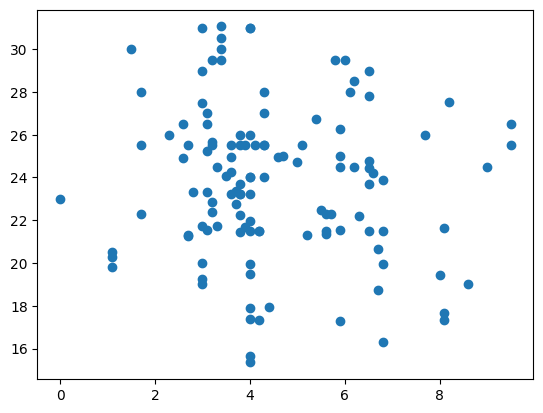

In [4]:
plt.scatter(data["Качество Эмитента"], data["Купон"])

In [5]:
data['Рейтинг'].unique()

array(['BB-', 'A', 'AA', 'B', 'BBB', 'BB', 'B+', nan], dtype=object)

In [6]:
data = data.dropna()

In [7]:
ratings = {
    'AA': 1,
    "A": 2,
    "BBB": 3,
    "BB": 4,
    "BB-": 5,
    "B+": 6,
    "B": 7,
}

In [8]:
def rating_to_number(row):
    return ratings[row['Рейтинг']]

In [9]:
data['numRating'] = data.apply(rating_to_number, axis=1)

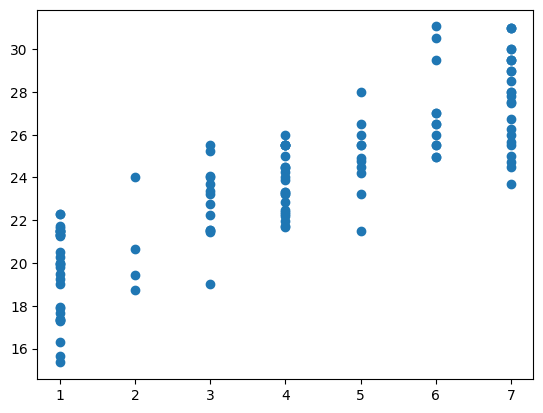

In [10]:
plt.scatter(data['numRating'], data['Купон'])

In [11]:
def caclulate_duration(row):
    date1 = row['Дата Выпуска']
    date2 = row['Дата Погашения / Оферты']
    date1 = datetime.strptime(date1, "%d.%m.%Y")
    date2 = datetime.strptime(date2, "%d.%m.%Y")
    td = date2 - date1
    years = td.days / 365
    return years

In [12]:
data['toMaturity'] = data.apply(caclulate_duration, axis=1)

In [13]:
data.head()

,Название,ISIN,Рейтинг,Качество Эмитента,Объем,Дата Выпуска,Дата Погашения / Оферты,Купон,Частота Выплат,Дюрация,numRating,toMaturity
0,МОНОПОЛИЯ 001P-03,RU000A10ARS4,BB-,2.6,3000,30.01.2025,26.01.2026,26.50,12,0.47,5,0.989041
1,ТГК-14 001Р-05,RU000A10AS02,BB-,6.5,4500,30.01.2025,11.01.2029,24.75,12,2.41,5,3.950685
2,ПАО ЛК Европлан 001P-09,RU000A10ASC6,A,4.0,16000,31.01.2025,14.07.2028,24.00,12,1.50,2,3.452055
3,Магнит ПАО БО-005Р-01,RU000A10ANZ8,AA,4.2,36000,24.01.2025,20.04.2026,21.50,12,0.67,1,1.235616
4,РОЛЬФ БО 001Р-07,RU000A10ASE2,BB-,3.8,1600,31.01.2025,21.01.2027,26.00,12,1.23,5,1.972603


In [14]:
risk_free_yields = pd.read_csv('zcyc_range_calculator.csv', sep=';', decimal=',')

In [15]:
risk_free_yields.head()

,tradedate,tradetime,period_0.25,period_0.5,period_0.75,period_1.0,period_1.5,period_2.0,period_2.5,period_3.0,period_3.5,period_4.0,period_5.0,period_7.0,period_10.0,period_15.0
0,03.01.2025,18:39:58,18.70,18.62,18.52,18.41,18.17,17.92,17.66,17.41,17.18,16.96,16.57,15.96,15.38,14.86
1,06.01.2025,18:39:58,19.10,18.96,18.82,18.66,18.34,18.03,17.72,17.43,17.16,16.91,16.48,15.81,15.18,14.63
2,08.01.2025,18:39:58,19.43,19.26,19.07,18.87,18.48,18.11,17.75,17.42,17.11,16.84,16.37,15.68,15.07,14.60
3,09.01.2025,18:39:58,18.77,18.68,18.57,18.46,18.22,17.97,17.72,17.48,17.27,17.07,16.72,16.19,15.64,15.08
4,10.01.2025,18:39:56,19.06,18.93,18.79,18.64,18.34,18.05,17.77,17.52,17.28,17.08,16.73,16.21,15.70,15.20


In [16]:
risk_free_yields['date'] = risk_free_yields.apply(lambda row: datetime.strptime(row["tradedate"], "%d.%m.%Y"), axis=1 ) 

In [17]:
data['dateStart'] = data.apply(lambda row: datetime.strptime(row["Дата Выпуска"], "%d.%m.%Y"), axis=1 ) 
data['dateEnd'] = data.apply(lambda row: datetime.strptime(row["Дата Погашения / Оферты"], "%d.%m.%Y"), axis=1 ) 

In [32]:
def get_risk_free_yield(start_date, to_maturity):
    items = risk_free_yields['date'].to_numpy()
    closest_date = nearest_date(items, start_date)
    periods = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0, 15.0]
    closest_period = get_closest_period(to_maturity, periods)
    column_name = get_col_name(closest_period)
    row = risk_free_yields.loc[risk_free_yields['date'] == closest_date]
    return row[column_name].values[0]

def get_col_name(period):
    return 'period_' + str(period)

def get_closest_period(value, periods):
    result = min(periods, key=lambda x: abs(x - value))
    return result

def nearest_date(items, pivot):
    return min([i for i in items if i <= pivot], key=lambda x: abs(x - pivot))

In [33]:
data['risk_free_yield_toMaturity'] = data.apply(lambda row: get_risk_free_yield(row['dateStart'], row['toMaturity']), axis=1)
data['risk_free_yield_toDuration'] = data.apply(lambda row: get_risk_free_yield(row['dateStart'], row['Дюрация']), axis=1)

In [127]:
data.head()

,Название,ISIN,Рейтинг,Качество Эмитента,Объем,Дата Выпуска,Дата Погашения / Оферты,Купон,Частота Выплат,Дюрация,numRating,toMaturity,dateStart,dateEnd,risk_free_yield_toMaturity,risk_free_yield_toDuration
0,МОНОПОЛИЯ 001P-03,RU000A10ARS4,BB-,2.6,3000,30.01.2025,26.01.2026,26.50,12,0.47,5,0.989041,2025-01-30,2026-01-26,18.32,18.62
1,ТГК-14 001Р-05,RU000A10AS02,BB-,6.5,4500,30.01.2025,11.01.2029,24.75,12,2.41,5,3.950685,2025-01-30,2029-01-11,17.21,17.64
2,ПАО ЛК Европлан 001P-09,RU000A10ASC6,A,4.0,16000,31.01.2025,14.07.2028,24.00,12,1.50,2,3.452055,2025-01-31,2028-07-14,17.33,18.06
3,Магнит ПАО БО-005Р-01,RU000A10ANZ8,AA,4.2,36000,24.01.2025,20.04.2026,21.50,12,0.67,1,1.235616,2025-01-24,2026-04-20,18.32,18.47
4,РОЛЬФ БО 001Р-07,RU000A10ASE2,BB-,3.8,1600,31.01.2025,21.01.2027,26.00,12,1.23,5,1.972603,2025-01-31,2027-01-21,17.84,18.32


In [43]:
def calculate_effective_yield(row):
    coupon = row['Купон']
    freq = row['Частота Выплат']
    return ((1 + coupon / 100 / freq)**freq - 1 ) * 100

In [44]:
data["effYield"] = data.apply(calculate_effective_yield, axis=1)

In [46]:
data.head()

,Название,ISIN,Рейтинг,Качество Эмитента,Объем,Дата Выпуска,Дата Погашения / Оферты,Купон,Частота Выплат,Дюрация,numRating,toMaturity,dateStart,dateEnd,risk_free_yield_toMaturity,risk_free_yield_toDuration,effYield
0,МОНОПОЛИЯ 001P-03,RU000A10ARS4,BB-,2.6,3000,30.01.2025,26.01.2026,26.50,12,0.47,5,0.989041,2025-01-30,2026-01-26,18.32,18.62,29.967773
1,ТГК-14 001Р-05,RU000A10AS02,BB-,6.5,4500,30.01.2025,11.01.2029,24.75,12,2.41,5,3.950685,2025-01-30,2029-01-11,17.21,17.64,27.759859
2,ПАО ЛК Европлан 001P-09,RU000A10ASC6,A,4.0,16000,31.01.2025,14.07.2028,24.00,12,1.50,2,3.452055,2025-01-31,2028-07-14,17.39,18.07,26.824179
3,Магнит ПАО БО-005Р-01,RU000A10ANZ8,AA,4.2,36000,24.01.2025,20.04.2026,21.50,12,0.67,1,1.235616,2025-01-24,2026-04-20,18.88,19.06,23.750426
4,РОЛЬФ БО 001Р-07,RU000A10ASE2,BB-,3.8,1600,31.01.2025,21.01.2027,26.00,12,1.23,5,1.972603,2025-01-31,2027-01-21,17.86,18.29,29.333398


In [48]:
data['premium'] = data['effYield'] - data['risk_free_yield_toMaturity']

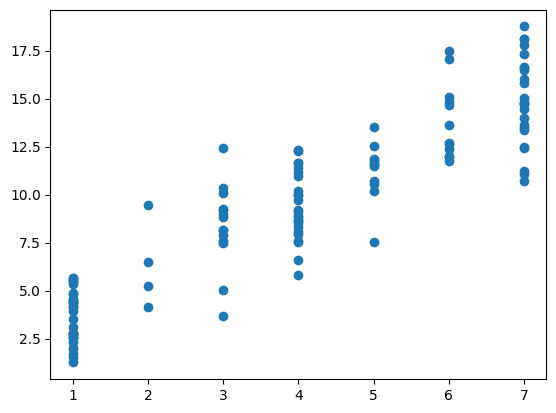

In [49]:
plt.scatter(data['numRating'], data['premium'])

In [50]:
data.to_csv('issuance_data.csv')

In [51]:
risk_free_yields.to_csv('risk_free_yields.csv')